In [20]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.engine.topology import get_source_inputs
from keras.layers import DepthwiseConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,regularizers
import numpy as np
from skimage.transform import resize
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import os

In [2]:
def get_annotations_map():
	valAnnotationsPath = './resized-tiny-imagenet-200/val/val_annotations.txt'
	valAnnotationsFile = open(valAnnotationsPath, 'r')
	valAnnotationsContents = valAnnotationsFile.read()
	valAnnotations = {}

	for line in valAnnotationsContents.splitlines():
		pieces = line.strip().split()
		valAnnotations[pieces[0]] = pieces[1]

	return valAnnotations

In [3]:
from PIL import Image

def load_images(path,num_classes):
    #Load images
    
    print('Loading ' + str(num_classes) + ' classes')

    X_train=np.zeros([num_classes*500,3,32,32],dtype='uint8')
    y_train=np.zeros([num_classes*500], dtype='uint8')

    trainPath=path+'/train'

    print('loading training images...');

    i=0
    j=0
    annotations={}
    for sChild in os.listdir(trainPath):
        if sChild == '.DS_Store':
            continue
        sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
#         print(sChildPath)
        annotations[sChild]=j
        for c in os.listdir(sChildPath):
            if c == '.DS_Store':
                continue
            X=np.array(Image.open(os.path.join(sChildPath,c)))
            if len(np.shape(X))==2:
                X_train[i]=np.array([X,X,X])
            else:
                X_train[i]=np.transpose(X,(2,0,1))
            y_train[i]=j
            i+=1
        j+=1
        if (j >= num_classes):
            break

    print('finished loading training images')

    val_annotations_map = get_annotations_map()

    X_test = np.zeros([num_classes*50,3,32,32],dtype='uint8')
    y_test = np.zeros([num_classes*50], dtype='uint8')


    print('loading test images...')

    i = 0
    testPath=path+'/val/images'
    for sChild in os.listdir(testPath):
        if sChild == '.DS_Store':
            continue
        if val_annotations_map[sChild] in annotations.keys():
            sChildPath = os.path.join(testPath, sChild)
            X=np.array(Image.open(sChildPath))
            if len(np.shape(X))==2:
                X_test[i]=np.array([X,X,X])
            else:
                X_test[i]=np.transpose(X,(2,0,1))
            y_test[i]=annotations[val_annotations_map[sChild]]
            i+=1
        else:
            pass

    X_train = X_train.transpose(0,2,3,1)
    X_test = X_test.transpose(0,2,3,1)
    print('finished loading test images')

    return X_train,y_train,X_test,y_test

In [4]:
path='./resized-tiny-imagenet-200'
x_train,y_train,x_test,y_test=load_images(path,200)

Loading 200 classes
loading training images...
finished loading training images
loading test images...
finished loading test images


In [5]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

In [8]:
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    elif epoch < 200:
        return 0.001
    else:
        return 0.0001

In [10]:
# process data
num_classes = 200
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

In [11]:
def depthwise_separable(x,params):
    # f1/f2 filter size, s1 stride of conv
    (s1,f2) = params
    x = DepthwiseConv2D((3,3),strides=(s1[0],s1[0]), padding='same',depthwise_initializer="he_normal")(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(f2[0]), (1,1), strides=(1,1), padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

In [12]:
def MobileNet(img_input, alpha=1, shallow=False, classes=10):
    
    x = Conv2D(int(32), (3,3), strides=(2,2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = depthwise_separable(x,params=[(1,),(64,)])
    x = depthwise_separable(x,params=[(2,),(128,)])
    x = depthwise_separable(x,params=[(1,),(128,)])
    x = depthwise_separable(x,params=[(2,),(256,)])
    x = depthwise_separable(x,params=[(1,),(256,)])
    x = depthwise_separable(x,params=[(2,),(512,)])
    
    if not shallow:
        for _ in range(5):
            x = depthwise_separable(x,params=[(1,),(512,)])
            
    x = depthwise_separable(x,params=[(2,),(1024,)])
    x = depthwise_separable(x,params=[(1,),(1024,)])

    x = GlobalAveragePooling2D()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return out

In [14]:
weight_decay=1e-4
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
model=Model(img_input,output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 32)        0         
__________

In [15]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

In [18]:
# start training
batch_size = 64
history = model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
1562/1562 [==============================] - 813s 521ms/step - loss: 16987.4797 - acc: 0.0167 - val_loss: 12223.0092 - val_acc: 0.0197
Epoch 2/10
1562/1562 [==============================] - 890s 570ms/step - loss: 9088.3061 - acc: 0.0283 - val_loss: 6539.2429 - val_acc: 0.0256
Epoch 3/10
1562/1562 [==============================] - 957s 613ms/step - loss: 4862.6614 - acc: 0.0377 - val_loss: 3499.3615 - val_acc: 0.0417
Epoch 4/10
1562/1562 [==============================] - 738s 472ms/step - loss: 2602.6897 - acc: 0.0452 - val_loss: 1873.6564 - val_acc: 0.0517
Epoch 5/10
1562/1562 [==============================] - 703s 450ms/step - loss: 1394.1107 - acc: 0.0490 - val_loss: 1004.3309 - val_acc: 0.0547
Epoch 6/10
1562/1562 [==============================] - 652s 418ms/step - loss: 747.8031 - acc: 0.0546 - val_loss: 539.4130 - val_acc: 0.0564
Epoch 7/10
1562/1562 [==============================] - 652s 417ms/step - loss: 402.1354 - acc: 0.0585 - val_loss: 290.6927 - val_acc: 0

In [19]:
model.save('saved_models/mobilenet.h5')

In [21]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 11s 1ms/step
Test loss: 48.55855615234375
Test accuracy: 0.076


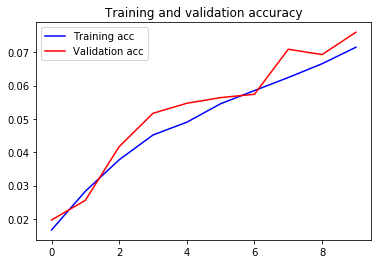

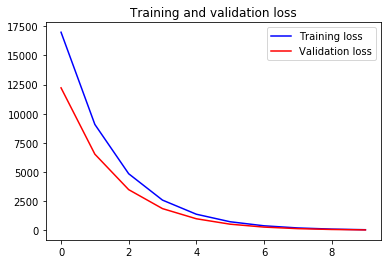

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()